In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
%matplotlib inline

import pandas as pd # data handling
import numpy as np # numerical computation packages in python
import cmath # for handling complex numbers
import matplotlib.pyplot as plt # plotting routines
from scipy.integrate import odeint # solving the system of differential equations
import scipy.optimize as opt

In [2]:
#PART 1- SOLVING NETWORK EQUATIONS

In [3]:
#1. Defining commonly used parameters

# Consumer/Generator vector. P_i = p if generator, P_i = -p if consumer 
p = 1 # value used in Nonlocal failures paper
P = np.asarray([-p, p, p, p, -p, -p, p, -p])

# damping constant
alpha = np.asarray([p]*8) # value used in Nonlocal failures paper- see fig 4

# Adjacency matrix. K[i,j] = k if link exists between nodes i and j, K[i,j] = 0 otherwise
# Link (0,1) is equivalent to link (1,2) in diagram

k = 1.03*p # value used in Nonlocal failures paper- see fig 4
dk = k # value used in Nonlocal failures paper- see fig 4
K = np.asarray([[0, k, 0, 0, 0, k, k, 0], 
                [k, 0, k, 0+dk, 0, 0, 0, 0], 
                [0, k, 0, k, 0, 0, k, 0],
                [0, 0+dk, k, 0, k, 0, 0, k],
                [0, 0, 0, k, 0, k, 0, 0],
                [k, 0, 0, 0, k, 0, 0, k],
                [k, 0, k, 0, 0, 0, 0, 0],
                [0, 0, 0, k, 0, k, 0, 0]])

# control vector
C = np.asarray([0]*8)
budget = .16

In [4]:
#2. System of equations describing the oscillator model
def oscillator_model(X, t, K, C, P, alpha):
    
    # i = node under consideration
    # j = coupled node
    
    # phi_0, ..., phi_7, omega_0, ..., omega_7  = X #unpacking state vector
    phi = np.asarray([X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7]])
    omega = np.asarray([X[8], X[9], X[10], X[11], X[12], X[13], X[14], X[15]])
    
    # preallocating vectors
    coupling = np.zeros((8,1))
    dphi = np.zeros((8,1))
    domega = np.zeros((8,1))
    
    # calculating coupling term of each omega equation
    for a in range(len(coupling)):
        for b in range(len(coupling)):
            coupling[a] = coupling[a] + K[a,b]*np.sin(phi[b]-phi[a])
      
    # system of equations to be solved
    dphi[0] = omega[0]
    dphi[1] = omega[1]
    dphi[2] = omega[2]
    dphi[3] = omega[3]
    dphi[4] = omega[4]
    dphi[5] = omega[5]
    dphi[6] = omega[6]
    dphi[7] = omega[7]
    domega[0] = - alpha[0]*omega[0] - C[0]*phi[0] + P[0] + coupling[0]
    domega[1] = - alpha[1]*omega[1] - C[1]*phi[1] + P[1] + coupling[1]
    domega[2] = - alpha[2]*omega[2] - C[2]*phi[2] + P[2] + coupling[2]
    domega[3] = - alpha[3]*omega[3] - C[3]*phi[3] + P[3] + coupling[3] 
    domega[4] = - alpha[4]*omega[4] - C[4]*phi[4] + P[4] + coupling[4]
    domega[5] = - alpha[5]*omega[5] - C[5]*phi[5] + P[5] + coupling[5]
    domega[6] = - alpha[6]*omega[6] - C[6]*phi[6] + P[6] + coupling[6]
    domega[7] = - alpha[7]*omega[7] - C[7]*phi[7] + P[7] + coupling[7]    
    
    # concatenating vectors into single solution vector
    dXdt = np.asarray([dphi, domega])
    dXdt = dXdt.reshape(16)
    
    return dXdt

In [5]:
#3. Use a package to solve the differential equation for 25 time units

#initial conditions x0=[phi_0, phi_1, ..., omega_0, omega_1, ...]
x0 = [.0]*16
t = np.linspace(0, 150, 15000) #time span

#solver
#sol_1 = odeint(oscillator_model, x0, t, args=(K,C,P,alpha)) #uncontrolled dynamics
sol_1 = odeint(oscillator_model, x0, t, args=(K,np.asarray([budget/8]*8),P,alpha)) #uniformly controlled dynamics
#sol_1 = odeint(oscillator_model, x0, t, args=(K,C_best,P,alpha)) #optimally controlled dynamics

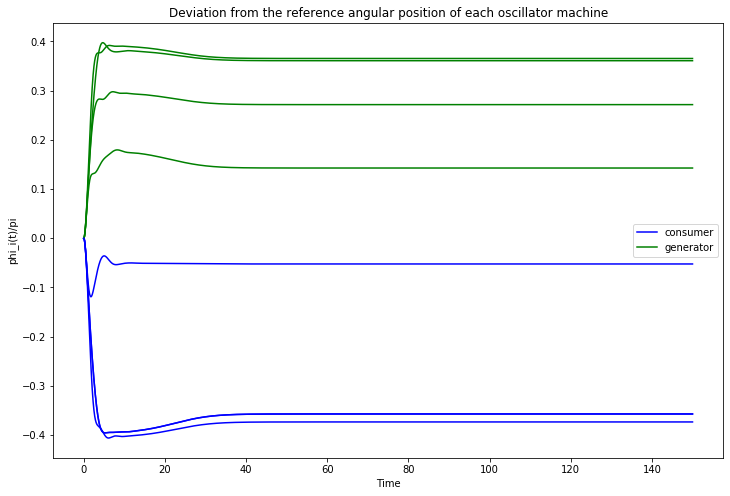

In [6]:
#4. Plotting time domain angular solutions of oscillator network
plt.figure(figsize=(12,8))
#plt.ylim((-.17,.17))
plt.plot(t, sol_1[:, 0]/np.pi, color='b', label='consumer')
plt.plot(t, sol_1[:, 1]/np.pi, color='g', label='generator')
plt.plot(t, sol_1[:, 2]/np.pi, color='g')
plt.plot(t, sol_1[:, 3]/np.pi, color='g')
plt.plot(t, sol_1[:, 4]/np.pi, color='b')
plt.plot(t, sol_1[:, 5]/np.pi, color='b')
plt.plot(t, sol_1[:, 6]/np.pi, color='g')
plt.plot(t, sol_1[:, 7]/np.pi, color='b')

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('phi_i(t)/pi')
plt.title('Deviation from the reference angular position of each oscillator machine');
#plt.savefig('opt_relax_time.jpg')
#plt.show()

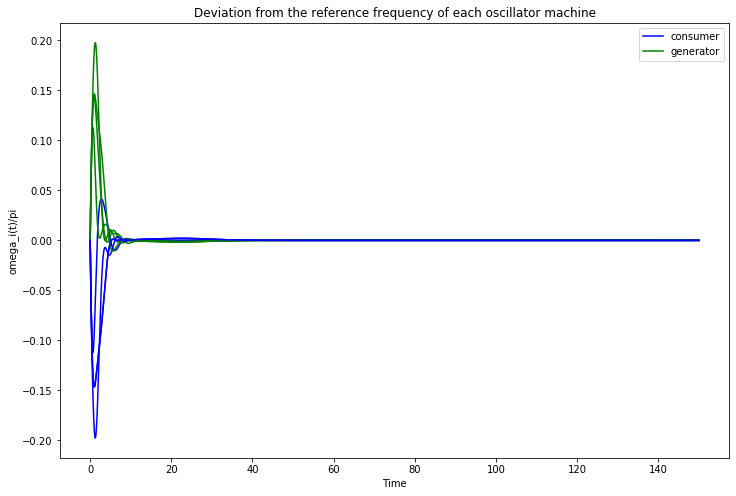

In [7]:
#5. Plotting time domain frequency solutions of oscillator network
plt.figure(figsize=(12,8))
#plt.ylim((-.15,.15))
plt.plot(t, sol_1[:, 8]/np.pi, color='b', label='consumer')
plt.plot(t, sol_1[:, 9]/np.pi, color='g', label='generator')
plt.plot(t, sol_1[:, 10]/np.pi, color='g')
plt.plot(t, sol_1[:, 11]/np.pi, color='g')
plt.plot(t, sol_1[:, 12]/np.pi, color='b')
plt.plot(t, sol_1[:, 13]/np.pi, color='b')
plt.plot(t, sol_1[:, 14]/np.pi, color='g')
plt.plot(t, sol_1[:, 15]/np.pi, color='b')

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('omega_i(t)/pi')
plt.title('Deviation from the reference frequency of each oscillator machine');
#plt.savefig('opt_second2.jpg')
#plt.show()

In [8]:
#PART 2- EXISTENCE OF FIXED POINT

In [9]:
#1. Integration method for finding fixed point
def fixed_point(final_ts, prev_ts, dt, tol):
    
    #compute time derivatives
    deriv = (final_ts - prev_ts)/dt
    
    #check for steady-state solution
    norm_2 = np.linalg.norm(deriv) 
    if (norm_2 < tol):
        ss = True
    else:
        ss = False
        
    return norm_2, ss, final_ts

In [10]:
tol = 10**-3 #tolerance for verifying derivative is zero
norm, ss, fp  = fixed_point(sol_1[len(sol_1)-1], sol_1[len(sol_1)-2], t[len(t)-1]-t[len(t)-2], tol)
print("Time derivative norm was:", norm, "\n")
print("Does a steady state exist?", ss, "\n")
print("The fixed point was: \n", fp)

Time derivative norm was: 1.4931540736508707e-09 

Does a steady state exist? True 

The fixed point was: 
 [-1.64506799e-01  8.53121889e-01  1.14784047e+00  4.48235518e-01
 -1.12246263e+00 -1.17340626e+00  1.13364042e+00 -1.12246263e+00
  4.46712293e-10  2.19324715e-10  3.86123646e-10  5.87326667e-10
  7.00494038e-11  7.14932478e-11  1.27547224e-10  7.00494038e-11]


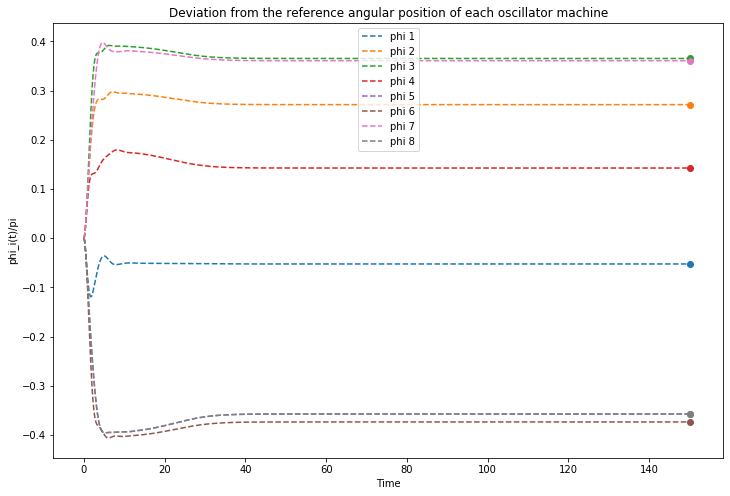

In [11]:
#3. Plotting fixed point against phase dynamics
plt.figure(figsize=(12,8))
plt.plot(t, sol_1[:, 0]/np.pi, '--', label="phi 1")
plt.plot(t, sol_1[:, 1]/np.pi, '--', label="phi 2")
plt.plot(t, sol_1[:, 2]/np.pi, '--', label="phi 3")
plt.plot(t, sol_1[:, 3]/np.pi, '--', label="phi 4")
plt.plot(t, sol_1[:, 4]/np.pi, '--', label="phi 5")
plt.plot(t, sol_1[:, 5]/np.pi, '--', label="phi 6")
plt.plot(t, sol_1[:, 6]/np.pi, '--', label="phi 7")
plt.plot(t, sol_1[:, 7]/np.pi, '--', label="phi 8")

plt.scatter(t[len(t)-1], fp[0]/np.pi)
plt.scatter(t[len(t)-1], fp[1]/np.pi)
plt.scatter(t[len(t)-1], fp[2]/np.pi)
plt.scatter(t[len(t)-1], fp[3]/np.pi)
plt.scatter(t[len(t)-1], fp[4]/np.pi)
plt.scatter(t[len(t)-1], fp[5]/np.pi)
plt.scatter(t[len(t)-1], fp[6]/np.pi)
plt.scatter(t[len(t)-1], fp[7]/np.pi)

plt.xlabel('Time')
plt.ylabel('phi_i(t)/pi')
plt.title('Deviation from the reference angular position of each oscillator machine');
plt.legend(loc="upper center")
#plt.savefig('opt_largest1.jpg')
#plt.show()

In [12]:
#PART 3- PERFORMANCE SPECIFICATION

In [13]:
#4. Settling Time- time taken to stay within delta of steady state value
def settling_time(t, sol, delta): 
    
    "measure settling time"
    
    # Settling Time- time taken to stay within delta of steady state value
    ss = sol[len(t)-1,:] # steady state
    st = np.asarray([0]*16) # settling time of each state variable
    st_index = np.asarray([np.inf]*len(t)) # vector for determining the settling of an individual variable

    for j in range(len(ss)):
        for i in range(len(t)):
            if(np.absolute(ss[j]/np.pi-sol[i,j]/np.pi) < delta):
                st_index[i] = 0 #index of last infinity corresponds to index of settling time

        for k in range(len(st_index)):
            if(st_index[k] == np.inf):
                st[j] = k # index of settling time for signal j
    
    return t[st[np.argmax(st)]] #, np.argmax(st)+1 # value of maximum settling time and which signal it occurs

In [14]:
sett_time = settling_time(t, sol_1, 10**-2.5)
print(sett_time)

6.720448029868658


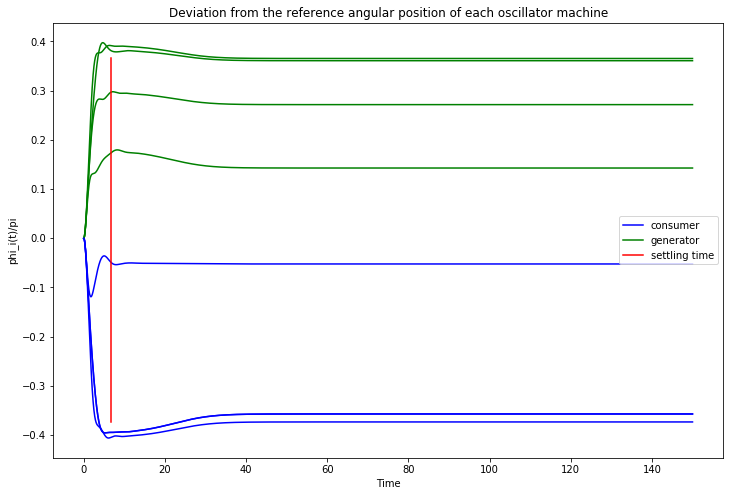

In [15]:
plt.figure(figsize=(12,8))
#plt.ylim((-.17,.17))
plt.plot(t, sol_1[:, 0]/np.pi, color='b', label='consumer')
plt.plot(t, sol_1[:, 1]/np.pi, color='g', label='generator')
plt.plot(t, sol_1[:, 2]/np.pi, color='g')
plt.plot(t, sol_1[:, 3]/np.pi, color='g')
plt.plot(t, sol_1[:, 4]/np.pi, color='b')
plt.plot(t, sol_1[:, 5]/np.pi, color='b')
plt.plot(t, sol_1[:, 6]/np.pi, color='g')
plt.plot(t, sol_1[:, 7]/np.pi, color='b')

plt.plot([sett_time]*20, np.linspace(np.min(sol_1[len(t)-1,:]/np.pi), np.max(sol_1[len(t)-1,:]/np.pi), 20),
         color="r", label="settling time")

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('phi_i(t)/pi')
plt.title('Deviation from the reference angular position of each oscillator machine');
#plt.savefig('fp_rand3.jpg')
#plt.show()

In [16]:
#PART 4- STABILITY ANALYSIS AROUND FIXED POINT

In [17]:
#1. Finds eigenvalues of the Laplacian and Jacobian. Returns ordered arrays with imaginary component removed
def find_eigs(K, C, alpha, fp):

    # i = node under consideration
    # j = coupled node
    
    # preallocating vectors
    L = np.zeros((8,8)) # Laplacian
    
    # calculating each Laplacian term
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):            
            if i!=j:
                L[i,j] = -K[i,j]*np.cos(fp[i] - fp[j])
            else:
                for l in range(L.shape[1]):
                    if l==i:
                        continue # excludes L[i,i]
                    L[i,j] = L[i,j] + K[i,l]*np.cos(fp[i] - fp[l])
    
    # converting system of equations into matrix form
    zero = np.zeros((8,8))
    one = np.eye(8)
    A = alpha*np.eye(8) # damping parameter is same for all nodes
    C = C*np.eye(8) # control matrix
    
    # joining matrices into one large system
    J1 = np.concatenate((zero, -L-C))
    J2 = np.concatenate((one, -A))
    J = np.concatenate((J1, J2), axis=1)
    
    # computing eigenvalues
    eig_L = np.linalg.eig(L)
    eig_J = np.linalg.eig(J)
    
    # extracting eigenvalues
    eig_L = eig_L[0]
    eig_J = eig_J[0]
    
    # converting to numpy arrays
    eig_L = np.asarray(eig_L)
    eig_J = np.asarray(eig_J)
    
    # removing imaginary component
    eig_J = eig_J.real
    
    # sorting eigenvalues into ascending order
    # the linked Jacobian eigenvalues without imaginary components will be at opposite ends of the array 
    eig_L.sort()
    eig_J.sort()
    
    # splitting array into two and reordering the second part of the array such that the same index maps to the same
    # Laplacian eigenvalue
    eig_J1 = eig_J[0:L.shape[0]]
    eig_J2 = eig_J[L.shape[0+1]:len(eig_J)]
    eig_J2 = sorted(eig_J2,reverse=True)
    
    # combining into one nx2 matrix
    eig_J = np.asarray([eig_J1, eig_J2])
    
    return eig_L, eig_J

In [19]:
#2. Storing eigenvalues of laplacian and jacobian

#eig_L_comp, eig_J_comp = find_eigs(K, C, alpha, fp) #uncontrolled eigenvalues
eig_L_comp, eig_J_comp = find_eigs(K, np.asarray([budget/8]*8), alpha, fp) #uniformly controlled eigenvalues
#eig_L_comp, eig_J_comp = find_eigs(K, C_best, alpha, fp) #optimally controlled eigenvalues- largest jacobian

print("Eigenvalues of Laplacian:\n", eig_L_comp, "\n")
print("Eigenvalues of Jacobian:\n", eig_J_comp, "\n")

Eigenvalues of Laplacian:
 [2.50270707e-16 1.72893281e-01 1.02876486e+00 1.21017894e+00
 1.35574955e+00 3.04707730e+00 3.56677271e+00 3.96870803e+00] 

Eigenvalues of Jacobian:
 [[-0.97958315 -0.73897012 -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-0.02041685 -0.26102988 -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]] 



In [20]:
#eig_L_best, eig_J_best = find_eigs(K, C_best, alpha, fp) #optimally controlled eigenvalues- second largest jacobian

#print("Eigenvalues of Laplacian:\n", eig_L_best, "\n")
#print("Eigenvalues of Jacobian:\n", eig_J_best, "\n")

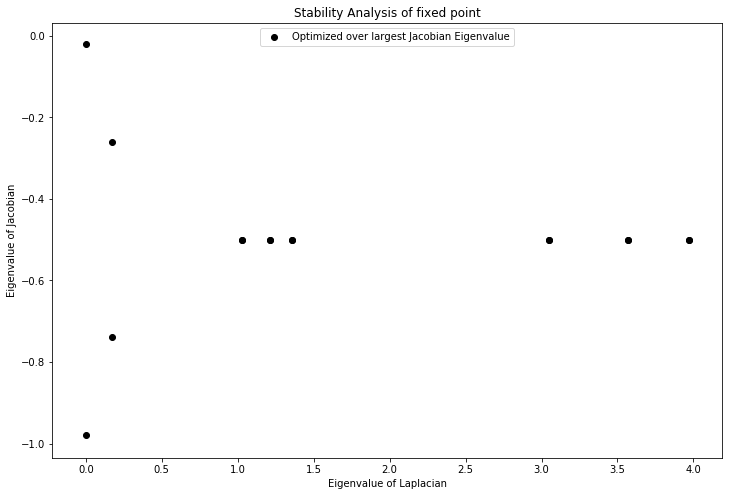

In [21]:
plt.figure(figsize=(12,8))
plt.scatter(eig_L_comp, eig_J_comp[0], color='k', label="Optimized over largest Jacobian Eigenvalue")
plt.scatter(eig_L_comp, eig_J_comp[1], color='k')
#plt.scatter(eig_L_best, eig_J_best[0], color='r', label="Optimized over relaxation time")
#plt.scatter(eig_L_best, eig_J_best[1], color='r')
plt.legend(loc='upper center')
plt.xlabel('Eigenvalue of Laplacian')
plt.ylabel('Eigenvalue of Jacobian')
plt.title('Stability Analysis of fixed point');
#plt.savefig('opt_rt_ev.jpg')
#plt.show()

In [22]:
#PART 5- OPTIMIZATION

In [28]:
#1. Defining objective function- largest jacobian eigenvalue
def max_eig(C, K, alpha, fp):

    # i = node under consideration
    # j = coupled node
    
    # preallocating vectors
    L = np.zeros((8,8)) # Laplacian
    
    # calculating each Laplacian term
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):            
            if i!=j:
                L[i,j] = -K[i,j]*np.cos(fp[i] - fp[j])
            else:
                for l in range(L.shape[1]):
                    if l==i:
                        continue # excludes L[i,i]
                    L[i,j] = L[i,j] + K[i,l]*np.cos(fp[i] - fp[l])
    
    # converting system of equations into matrix form
    zero = np.zeros((8,8))
    one = np.eye(8)
    A = alpha*np.eye(8) # damping parameter is same for all nodes
    C = C*np.eye(8) # control matrix
    
    # joining matrices into one large system
    J1 = np.concatenate((zero, -L-C))
    J2 = np.concatenate((one, -A))
    J = np.concatenate((J1, J2), axis=1)
    
    # computing eigenvalues
    eig_J = np.linalg.eig(J)
    
    # extracting eigenvalues
    eig_J = eig_J[0]
    
    # converting to numpy arrays
    eig_J = np.asarray(eig_J)
    
    # removing imaginary component
    eig_J = eig_J.real
    
    #sorting into order
    eig_J.sort()
    
    return eig_J[len(eig_J)-2]

In [29]:
# simple custom implementation- too check if non-uniform allocation provides improved stability

In [30]:
def rand_dist(budget, K, P, alpha, x0, t, tol, iters):
    
    #initialising with uniform solution
    C = np.asarray([budget/8]*8)
    
    #compute uniform fixed point and eigenvalue (if fixed point exists)
    sol = odeint(oscillator_model, x0, t, args=(K,C,P,alpha))
    norm2, s_s, f_p  = fixed_point(sol[len(sol)-1], sol[len(sol)-2], t[len(t)-1]-t[len(t)-2], tol)
    if(s_s):
        init_e = max_eig(C, K, alpha, f_p)
    else:
        init_e = np.inf
    
    #update variables for tracking optimized network stability 
    C_best = C + np.zeros(8) # storing best input
    best_eig = init_e # storing lowest max eigenvalue
    best_fp = f_p
    
    successful_tests = 0 
    
    for i in range(iters): 
        
        # randomly redistribute budget allocation
        node1 = np.random.randint(0,8) # randomly choose a node to subtract a random allocation from
        node2 = np.random.randint(0,8) # randomly choose a node to ad a random allocation to
        allocation = (budget/8)*np.random.random() # random floats between 0 and budget/8
        C[node1] = C[node1] - allocation
        C[node2] = C[node2] + allocation
        
        if(min(C) <= 0): # if reallocated budget has a non-positive element, return to previous allocation
            C[node1] = C[node1] + allocation
            C[node2] = C[node2] - allocation
            continue
        
        #compute fixed point and eigenvalue
        sol = odeint(oscillator_model, x0, t, args=(K,C,P,alpha))
        norm2, s_s, f_p  = fixed_point(sol[len(sol)-1], sol[len(sol)-2], t[len(t)-1]-t[len(t)-2], tol)
        if(s_s):
            max_e = max_eig(C, K, alpha, f_p) # compute max eigenvalue for given C
        else:
            C[node1] = C[node1] + allocation
            C[node2] = C[node2] - allocation
            continue
        
        successful_tests += 1
        
        if (max_e < best_eig): # update best value if it has been improved upon
            C_best = C + np.zeros(8)
            best_eig = max_e
            best_fp = f_p
        
    return init_e, C_best, best_eig, best_fp, successful_tests

In [31]:
iterations = 10
init_e, C_best, best_eig, best_fp, successful_tests = rand_dist(budget, K, P, alpha, x0, t, tol, iterations)
print("Out of", iterations, "iterations, the number of successful simulations was", successful_tests, "\n")
print("Maximum eigenvalue of uniform solution was: ", init_e, "\n")
print("   Maximum eigenvalue of best solution was: ", best_eig, "\n")
print("Uniform control allocation was: ", np.asarray([budget/8]*8), "\n")
print("   Best control allocation was: ", C_best, "\n")
print("Best fixed point was: \n", best_fp, "\n")

Out of 10 iterations, the number of successful simulations was 2 

Maximum eigenvalue of uniform solution was:  -0.2610287490352406 

   Maximum eigenvalue of best solution was:  -0.26102874927775443 

Uniform control allocation was:  [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02] 

   Best control allocation was:  [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02] 

Best fixed point was: 
 [-1.64506783e-01  8.53122023e-01  1.14784062e+00  4.48235676e-01
 -1.12246284e+00 -1.17340643e+00  1.13364057e+00 -1.12246283e+00
 -3.32590619e-09 -3.35584655e-08 -4.03293851e-08 -4.05156986e-08
  5.42138427e-08  4.52537459e-08 -3.60843244e-08  5.42492449e-08] 



In [179]:
# Optimizing over the largest Jacobian eigenvalue

# Out of 10000 iterations, the number of successful simulations was 1620 

# Maximum eigenvalue of uniform solution was:  -0.020416847668728266 

#    Maximum eigenvalue of best solution was:  -0.020416847668728266 

# Uniform control allocation was:  [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02] 

#    Best control allocation was:  [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02] 

# Best fixed point was: 
#[-1.64506783e-01,  8.53122023e-01,  1.14784062e+00,  4.48235676e-01, 
# -1.12246283e+00, -1.17340643e+00,  1.13364057e+00, -1.12246283e+00, 
# -3.28487646e-09, -3.36274460e-08, -4.02068460e-08, -4.05527403e-08, 
#  5.43127786e-08,  4.53183088e-08, -3.60505037e-08,  5.43127786e-08] 

In [ ]:
# Optimizing over the second Jacobian eigenvalue

# Out of 10000 iterations, the number of successful simulations was 1660 

# Maximum eigenvalue of uniform solution was:  -0.2610287490352406 

#    Maximum eigenvalue of best solution was:  -0.49999999999999967 

# Uniform control allocation was:  [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02] 

#    Best control allocation was:  [0.02014306 0.02068515 0.01851059 0.02000307 0.01735078 0.03680185
# 0.02078043 0.00572508] 

# Best fixed point was: 
# [-9.54078571e-01  6.14957294e+00  6.40035320e+00  5.77693698e+00
# -7.88675888e+00 -7.93875674e+00  6.37647113e+00 -7.94886925e+00
# -1.61169391e-06 -1.72566051e-06 -1.67014424e-06 -1.72807670e-06
# -1.67418477e-06 -1.60168302e-06 -1.65430041e-06 -1.68549722e-06] 

In [13]:
#2. Alternative objective function- settling time

In [53]:
def sett_time_opt(budget, x0, t, K, P, alpha, fp_tol, st_tol, iters, repeats):
    
    #initialising with uniform solution
    #C = np.asarray([budget/8]*8)
    #C = np.asarray([0.00845681, 0.00507198, 0.01000126, 0.01060301, 0.00570727, 0.00218151, 0.03126428, 0.08671388]) 
    
    #compute uniform fixed point
    sol = odeint(oscillator_model, x0, t, args=(K,C,P,alpha))
    norm2, s_s, f_p  = fixed_point(sol[len(sol)-1], sol[len(sol)-2], t[len(t)-1]-t[len(t)-2], fp_tol)
    
    st = np.asarray([0.0]*repeats)
    init_var_st = 0.0 # variance of settling time
    
    #if fixed point exists, compute average settling time  
    if(s_s):
        for i in range(repeats):
            fp_perturbed = f_p + np.random.uniform(-.2, .2, len(f_p))
            sol = odeint(oscillator_model, fp_perturbed, t, args=(K,C,P,alpha))
            st[i] = settling_time(t, sol, st_tol)
            
        init_av_st = np.sum(st)/repeats 
        
        for i in range(len(st)):
            init_var_st = init_var_st + (st[i] - init_av_st)**2
        init_var_st = init_var_st/repeats
        
        successful_tests = 1

    else:
        init_av_st = np.inf
        init_var_st = np.inf
        successful_tests = 0
    
    #update variables for tracking optimized network stability 
    C_best = C + np.zeros(8) # storing best input
    best_av_st = init_av_st # storing lowest average st
    best_var_st = init_var_st # storing var of best st
    best_fp = f_p # fp of best st
    
    for i in range(iters): 
        
        print(i, "\n")
        
        # randomly redistribute budget allocation
        node1 = np.random.randint(0,8) # randomly choose a node to subtract a random allocation from
        node2 = np.random.randint(0,8) # randomly choose a node to ad a random allocation to
        allocation = (budget/8)*np.random.random() # random floats between 0 and budget/8
        C[node1] = C[node1] - allocation
        C[node2] = C[node2] + allocation
        
        if(min(C) <= 0): # if reallocated budget has a non-positive element, return to previous allocation
            C[node1] = C[node1] + allocation
            C[node2] = C[node2] - allocation
            continue
        
        #compute uniform fixed point
        sol = odeint(oscillator_model, x0, t, args=(K,C,P,alpha))
        norm2, s_s, f_p  = fixed_point(sol[len(sol)-1], sol[len(sol)-2], t[len(t)-1]-t[len(t)-2], fp_tol)
        
        var_st = 0.0 # variance of settling time
        
        #if fixed point exists, compute average settling time
        if(s_s):
            for i in range(repeats):
                fp_perturbed = f_p + np.random.uniform(-.2, .2, len(f_p))
                sol = odeint(oscillator_model, fp_perturbed, t, args=(K,C,P,alpha))
                st[i] = settling_time(t, sol, st_tol)
            
            av_st = np.sum(st)/repeats 

            for i in range(len(st)):
                var_st = var_st + (st[i] - av_st)**2
            var_st = var_st/repeats

        else:
            C[node1] = C[node1] + allocation
            C[node2] = C[node2] - allocation
            continue
        
        successful_tests += 1
        
        if (av_st < best_av_st): # update best value if it has been improved upon
            C_best = C + np.zeros(8)
            best_av_st = av_st
            best_var_st = var_st
            best_fp = f_p
    
    return init_av_st, best_av_st, best_var_st, C_best, best_fp, successful_tests

In [54]:
uniform_time, opt_st, var_st, C_best, best_fp, no_tests = sett_time_opt(budget, x0, t, K, P, alpha, fp_tol=10**-3,
                                                                       st_tol=10**-2.5, iters=1, repeats=20)

print("Average settling time of uniform solution was:", uniform_time, "\n")
print("The optimal average settling time was", opt_st, "which occured when the control allocation was:\n", C_best, "\n")
print("The variance of the optimal settling time was:", var_st, "\n")
print("The number of random control allocations considered was:", no_tests)

0 

Average settling time of uniform solution was: 59.55197013134208 

The optimal average settling time was 59.55197013134208 which occured when the control allocation was:
 [0.00845681 0.00507198 0.01000126 0.01060301 0.00570727 0.00218151
 0.03126428 0.08671388] 

The variance of the optimal settling time was: 1582.5095002333221 

The number of random control allocations considered was: 2


In [ ]:
# run time 3 hours 10 mins for 100 iterations

# started @ 10.00
# i = 20 @ 11.00 
# i = 28 @ 11.15
# i = 50 @ 12.00
# i = 66 @ 12.35
# i = 76 @ 13.00
# i = 95 @ 13.35
# i = 112 @ 14.10
# i = 144 @ 15.20
# i = 166 @ 16.10
# i = 213 @ 17.55
# i = 249 @ 19.10
# i = 265 @ 19.35
# i = 334 @ 21.50
# i = 405 @ 00.10

# 500 iterations, 20 repeats, network C, budget= .16, fp_tol= 10**-3, st_tol= 10**-2.5
# Average settling time of uniform solution was: 56.711667116671165 

# The optimal average settling time was 41.91289412894129 which occured when the control allocation was:
#  [0.00181001 0.01494541 0.00870855 0.03768638 0.00811953 0.04310789
#  0.02337828 0.02224395] 

# The variance of the optimal settling time was: 1499.0218906497855 

# The number of random control allocations considered was: 349

In [25]:
#3. Relaxation time
def relax_time(sol, t):
    
    sol = sol[:, 0:8] #removing frequency dynamics
    
    # standard order parameter
    r = np.exp(sol*1j)
    r = np.sum(r, axis=1)/len(sol[0])
    r = np.absolute(r) # r(t)
    
    r_0 = r[2000] # r_0 == r_20
    r_infinity = r[9999] # r_infinity == r_100
    dt = t[len(t)-1] - t[len(t)-2]
    #print(r_0,"\n", r_infinity, "\n")
    
    r = r[2000:10000] # slice r down to interval between 20 and 100
    
    # making arrays of equal lengths to r
    r_0 = np.asarray([r_0]*len(r))
    r_infinity = np.asarray([r_infinity]*len(r))
    dt = np.asarray([dt]*len(r))
    
    r_hat = (r_infinity - r) / (r_infinity - r_0) # r _hat
    r_hat = np.absolute(r_hat)
    
    # relaxation time
    relax_t = np.dot(r_hat, dt)

    return relax_t

In [28]:
def relax_time_opt(budget, x0, t, K, P, alpha, fp_tol, st_tol, iters, repeats):
    
    #initialising with uniform solution
    C = np.asarray([budget/8]*8) 
    
    #compute uniform fixed point
    sol = odeint(oscillator_model, x0, t, args=(K,C,P,alpha))
    norm2, s_s, f_p  = fixed_point(sol[len(sol)-1], sol[len(sol)-2], t[len(t)-1]-t[len(t)-2], fp_tol)
    
    rt = np.asarray([0.0]*repeats)
    init_var_rt = 0.0 # variance of relax time
    
    #if fixed point exists, compute average relax time  
    if(s_s):
        for i in range(repeats):
            fp_perturbed = f_p + np.random.uniform(-.2, .2, len(f_p))
            sol = odeint(oscillator_model, fp_perturbed, t, args=(K,C,P,alpha))
            rt[i] = relax_time(sol, t)
            
            plt.figure(figsize=(12,8))
            #plt.ylim((-.17,.17))
            plt.plot(t, sol[:, 0]/np.pi, color='b', label='consumer')
            plt.plot(t, sol[:, 1]/np.pi, color='g', label='generator')
            plt.plot(t, sol[:, 2]/np.pi, color='g')
            plt.plot(t, sol[:, 3]/np.pi, color='g')
            plt.plot(t, sol[:, 4]/np.pi, color='b')
            plt.plot(t, sol[:, 5]/np.pi, color='b')
            plt.plot(t, sol[:, 6]/np.pi, color='g')
            plt.plot(t, sol[:, 7]/np.pi, color='b')

            plt.plot([rt[i]]*20, np.linspace(np.min(sol[len(t)-1,:]/np.pi), np.max(sol[len(t)-1,:]/np.pi), 20),
                     color="r", label="relaxation time")
            
            plt.savefig('relax_time_eg.jpg')
            plt.show()
            
        init_av_rt = np.sum(rt)/repeats # average relax time for uniform case 
        
        for i in range(len(rt)):
            init_var_rt = init_var_rt + (rt[i] - init_av_rt)**2
        init_var_rt = init_var_rt/repeats # varianca of relax time for uniform case
        
        successful_tests = 1

    else:
        init_av_rt = np.inf
        init_var_rt = np.inf
        successful_tests = 0
    
    #update variables for tracking optimized network stability 
    C_best = C + np.zeros(8) # storing best input
    best_av_rt = init_av_rt # storing lowest average st
    best_var_rt = init_var_rt # storing var of best st
    best_fp = f_p # fp of best st
    
    for i in range(iters): 
        
        print(i, "\n")
        
        # randomly redistribute budget allocation
        node1 = np.random.randint(0,8) # randomly choose a node to subtract a random allocation from
        node2 = np.random.randint(0,8) # randomly choose a node to ad a random allocation to
        allocation = (budget/8)*np.random.random() # random floats between 0 and budget/8
        C[node1] = C[node1] - allocation
        C[node2] = C[node2] + allocation
        
        if(min(C) <= 0): # if reallocated budget has a non-positive element, return to previous allocation
            C[node1] = C[node1] + allocation
            C[node2] = C[node2] - allocation
            continue
        
        #compute uniform fixed point
        sol = odeint(oscillator_model, x0, t, args=(K,C,P,alpha))
        norm2, s_s, f_p  = fixed_point(sol[len(sol)-1], sol[len(sol)-2], t[len(t)-1]-t[len(t)-2], fp_tol)
        
        var_rt = 0.0 # variance of settling time
        
        #if fixed point exists, compute average relax time
        if(s_s):
            for i in range(repeats):
                fp_perturbed = f_p + np.random.uniform(-.2, .2, len(f_p))
                sol = odeint(oscillator_model, fp_perturbed, t, args=(K,C,P,alpha))
                rt[i] = relax_time(sol, t)
            
            av_rt = np.sum(rt)/repeats 

            for i in range(len(rt)):
                var_rt = var_rt + (rt[i] - av_rt)**2
            var_rt = var_rt/repeats

        else:
            C[node1] = C[node1] + allocation
            C[node2] = C[node2] - allocation
            continue
        
        successful_tests += 1
        
        if (av_rt < best_av_rt): # update best value if it has been improved upon
            C_best = C + np.zeros(8)
            best_av_rt = av_rt
            best_var_rt = var_rt
            best_fp = f_p
    
    return best_av_rt, best_var_rt, C_best, best_fp, successful_tests

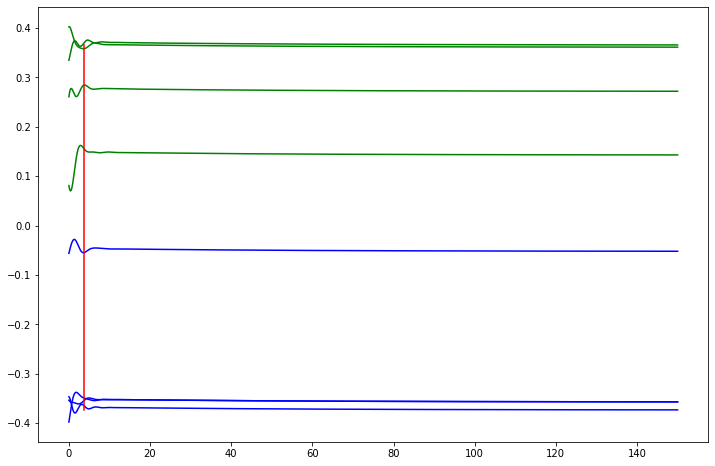

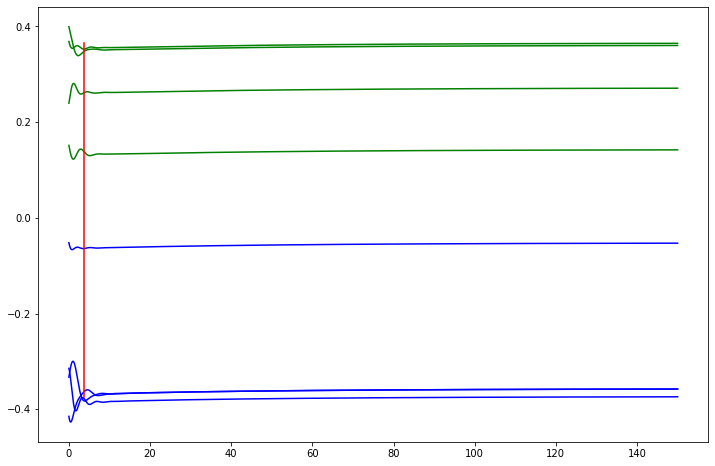

0 

The optimal relax time was: 3.819269130419758 

The variance of the optimal relax time was: 0.0001922681086772703 

This occured when the control allocation was: 
 [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02] 



In [29]:
relax = relax_time_opt(budget, x0, t, K, P, alpha, fp_tol=10**-3, st_tol=10**-2.5, iters=1, repeats=2)
print("The optimal relax time was:", relax[0], "\n")
print("The variance of the optimal relax time was:", relax[1], "\n")
print("This occured when the control allocation was: \n", relax[2], "\n")

In [33]:
# minimising relax time
#C_best = np.asarray([0.00845681, 0.00507198, 0.01000126, 0.01060301, 0.00570727, 0.00218151, 0.03126428, 0.08671388]) 

In [162]:
#C_best = np.asarray([budget/8]*8) # maximising largest jacobian
#C_best = np.asarray([.0201, .0207, .0185, .0200, .0174, .03680, .0208, .0057]) #maximizing second largest jacobian

6.969790520735601